In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

In [2]:
## Definitions ##
stims_path = './stims/'
target_path = './target_volts/'
sweep_filter_1 = [str(e) for e in range(79, 100)]
sweep_filter_2 = ['101', '102', '103']
sweep_filter = sweep_filter_1 + sweep_filter_2

# This is the original cell
stims_to_match = h5py.File('./filtered_dataset/cell_488683425/allen_data_stims_10000.hdf5', 'r')
sweep_index_to_match = ['4',\
                        '23',\
                        '22',\
                        '48_3',\
                        '53_3',\
                        '51_1',\
                        '58',\
                        '48_1',\
                        '66',\
                        '48_2',\
                        '44',\
                        '16',\
                        '38',\
                        '28',\
                        '13',\
                        '18',\
                        '15',\
                        '14']

In [3]:
model_number = '485835016'

In [4]:
#model_numbers = ['485835016','485880739','487664663' ,'485838981']
#model_numbers = [487664663]
model_numbers = [485835016]

In [5]:
stims_file_str = stims_path+'allen_data_stims_{}.hdf5'
target_file_str = target_path+'allen_data_target_volts_{}.hdf5'
#stims = h5py.File(stims_file_str.format(model_number), 'r')
#target_volts = h5py.File(target_file_str.format(model_number), 'r')
#sweep_keys = [e.decode('ascii') for e in stims['sweep_keys']]

In [6]:
# for key in sweep_keys:
#     print("Stim sweep number", key)
#     plt.plot(stims[key])
#     plt.show()

In [7]:
# xander
def get_target_volts(target_path, model_number):
    target_file_str = target_path+'allen_data_target_volts_{}.hdf5'
    target_volts = h5py.File(target_file_str.format(model_number), 'r')
    return target_volts

def get_stims(stims_path, model_number):
    stims_file_str = stims_path+'allen_data_stims_{}.hdf5'
    stims = h5py.File(stims_file_str.format(model_number), 'r')
    return stims
    
def get_sweep_keys(stims):
    sweep_keys = [e.decode('ascii') for e in stims['sweep_keys']] 
    return sweep_keys
    
def plot_sweep_keys(sweep_keys,stims,sweep_filter):
    for key in sweep_keys:
        if not key in sweep_filter:
            print("Stim sweep number", key)
            print("Max val:", np.max(stims[key]))
            print("Min val:", np.min(stims[key]))
            plt.plot(stims[key])
            plt.show()
# targetVolts = get_target_volts(target_path, model_number )
# stims = get_stims(stims_path,model_number)
# sweep_keys = get_sweep_keys(stims)


In [70]:
def match_sweeps(stim,stims_to_match, sweep_keys, sweeep_index_to_match, allow_dup = False, verbose=True, show=True):
    """
    Args:
        stim: stim we are going to match
        stims_to_match: reference to match with
        sweep_keys: sweep keys of stim we have
        sweeep_index_to_match: ?
        show: plot to check?
    """
    matched_sweep_numbers = []
    sweep_map_to_original = []
    seen = []
    for stim_num in sweep_index_to_match:
        match_stim = stims_to_match[stim_num]
        if verbose:
            print("Original sweep number:", stim_num)
        if show:
            plt.plot(match_stim, color='red')
            plt.show()
        for key in sweep_keys:
            if key in seen and not allow_dup:
                continue
            if not key in sweep_filter_1+sweep_filter_2:
                curr_stim = stims[key]
                len_to_div = len(curr_stim) / 10000
                curr_start = np.argmax(np.array(curr_stim) > 0) / len_to_div
                match_start = np.argmax(np.array(match_stim) > 0) 
                same_start = np.abs(curr_start - match_start) <  300
                diff_max = abs(np.max(match_stim)-np.max(curr_stim))
                diff_min = abs(np.min(match_stim)-np.min(curr_stim))
                #if diff_max < 0.0005 and diff_min < 0.0005:
                if diff_max < 0.0005 and diff_min < 0.0005:
                    if verbose:
                        print("Matched sweep number:", key)
                    matched_sweep_numbers.append(key)
                    sweep_map_to_original.append(stim_num)
                    seen.append(key)
                    if show:
                        plt.plot(curr_stim)
                        plt.show()
    return matched_sweep_numbers, sweep_map_to_original

def sample(input_vec, target_len, curr_dt=None):
    vec_len = len(input_vec)
    scale_factor = int(vec_len/target_len)
    dt =  (vec_len/target_len) * .02
    sampled_vec = []
    for i in range(0, vec_len, scale_factor):
        window = input_vec[i:i+scale_factor]
        sampled_vec.append(np.max(window))
    return sampled_vec, dt

def downsample(stims, target_volts, matched_sweep_numbers, resolution=10000, show=True):
    volt_res = {}
    stim_res = {}
    dts = {}
    for sweep_num in matched_sweep_numbers:
        curr_volt = target_volts[sweep_num][:]
        curr_stim = stims[sweep_num][:]
        dts[sweep_num] = resolution/len(curr_volt)
        curr_volt_sampled,_ = sample(curr_volt, resolution, dts[sweep_num])#target_volts['{}_dt'.format(sweep_num)][0])
        curr_stim_sampled,_ = sample(curr_stim, resolution, dts[sweep_num])#target_volts['{}_dt'.format(sweep_num)][0])
        if len(curr_stim_sampled) != 10000:
            # I don't think this is an issue, since nothing important is getting cutoff
            # see comment
            #print("Warning...stim for {} is not len 10k, .... truncating (TODO: Recalc DT)".format(sweep_num))
            #print("truncated by : ", len(curr_stim_sampled) - 10000)
            if len(curr_stim_sampled) - 10000 > 1000 and show:
                plt.figure()
                plt.plot(curr_stim_sampled)
                plt.plot(curr_stim_sampled[:10000])
            curr_stim_sampled = curr_stim_sampled[:10000]
            curr_volt_sampled = curr_volt_sampled[:10000]
            
        volt_res[sweep_num] = curr_volt_sampled
        stim_res[sweep_num] = curr_stim_sampled
        assert len(curr_stim_sampled) == 10000
        if show:
            plt.plot(curr_volt)
            plt.show()
            plt.plot(curr_volt_sampled, color='red')
            #plt.plot(curr_stim_sampled, color='green')

            plt.show()
    return volt_res, stim_res, dts

def save_results_hdf5(model_number, stims, target_volts, dts, \
                      sweep_index_to_match, matched_sweep_numbers, sweep_map_to_original):
    if not os.path.isdir("results/{}".format(model_number)):
        os.mkdir("results/{}".format(model_number))
    if os.path.isfile("results/{}/stims_{}.hdf5".format(model_number,model_number)):
        os.remove("results/{}/stims_{}.hdf5".format(model_number,model_number))
    if os.path.isfile("results/{}/target_volts_{}.hdf5".format(model_number,model_number)):
        os.remove("results/{}/target_volts_{}.hdf5".format(model_number,model_number))
    stim_file = h5py.File("results/{}/stims_{}.hdf5".format(model_number,model_number), "w")
    target_file = h5py.File("results/{}/target_volts_{}.hdf5".format(model_number,model_number), "w")
    correspondance = []
    seen = []
    skipped =0
    ct = 0
    for sweep_num,mapped_sweep in zip(matched_sweep_numbers, sweep_map_to_original):
        assert len(stims[sweep_num]) == 10000, "not saving stim, it's wrong len"
        ct += 1
        if sweep_num in seen:
            skipped += 1
            continue
        else:
            seen.append(sweep_num)
        stim_file.create_dataset(sweep_num,data= stims[sweep_num])
        stim_file.create_dataset("{}_dt".format(sweep_num),data=[dts[sweep_num]])
        target_file.create_dataset(sweep_num, data=target_volts[str(sweep_num)])
        correspondance.append(mapped_sweep)
    correspondance = [n.encode("ascii", "ignore") for n in correspondance]
    matched_sweep_numbers = [n.encode("ascii", "ignore") for n in matched_sweep_numbers]
    matched_sweep_numbers_int = [int(num) for num in matched_sweep_numbers]
    stim_file.create_dataset("corresponding_original", data=correspondance)
    stim_file.create_dataset("sweep_keys", data=matched_sweep_numbers)
    stim_file.create_dataset("sweep_nums", data=matched_sweep_numbers_int)

    target_file.close()
    target_file.close()
    print("then SKIPPED", skipped, " and saved: ", ct)
    print("---------- Saved data for {}  ---------".format(model_number))
    print("--------------------------------------")
def check_volts(model_number):
    f = h5py.File("results/{}/target_volts_{}.hdf5".format(model_number,model_number), "r")
    for key in f.keys():
        print(f[key][0], "Start volt")
        assert len(f[key][:]) == 10000, "Voltage is wrong length: {}".format(len(f[key][:]))

def check_stims(model_number):
    f = h5py.File("results/{}/stims_{}.hdf5".format(model_number,model_number), "r")
    all_keys = list(f.keys())
    sweep_keys = [key.decode('ascii') for key in f['sweep_keys'][:]]
    for key in sweep_keys:
        assert "{}_dt".format(key) in all_keys
        #print(int(f["{}_dt".format(key)]))
        assert f["{}_dt".format(key)][0] < 1, "Dt is weird"
        assert len(f[key][:]) == 10000, "stim is wrong length:  {}".format(len(f[key][:]))

In [71]:
def match_sweep_and_save(model_numbers):
    for model_number in model_numbers:
        target_volts = get_target_volts(target_path, model_number )
        stims = get_stims(stims_path,model_number)
        sweep_keys = get_sweep_keys(stims)
        matched_sweep_numbers, sweep_map_to_original = match_sweeps(stims, stims_to_match, sweep_keys, \
                                             sweep_index_to_match, allow_dup=False, verbose=False,show=False)
        print("--------------------------------------")
        filler = sweep_map_to_original[-1]
        sweep_map_to_original.extend([filler,filler,filler,filler,filler])
        sweepNum2volt, sweepNum2Stim, dts = downsample(stims, target_volts, matched_sweep_numbers, show=False)

        save_results_hdf5(model_number, sweepNum2Stim, sweepNum2volt, dts, \
                          sweep_index_to_match, matched_sweep_numbers, sweep_map_to_original)


In [72]:
# for model_number in model_numbers:
#     print("checking - {}".format(model_number))
#     check_stims(model_number)
#     check_volts(model_number)

In [73]:
# stims to add is a string list of stims to add
def add_stim(model_number,stims_to_add=None,show=True):
    all_target_volts = get_target_volts(target_path, model_number )
    all_stims = get_stims(stims_path,model_number)
    
    stim_f = h5py.File("results/{}/stims_{}.hdf5".format(model_number,model_number), "a")
    all_stim_keys = list(stim_f.keys())
    volt_f = h5py.File("results/{}/target_volts_{}.hdf5".format(model_number,model_number), "a")
    all_volt_keys = list(volt_f.keys())
    obj_f = h5py.File("results/{}/allen{}_objectives.hdf5".format(model_number,model_number), "r")
    if os.path.isfile("results/{}/allen{}_objectives2.hdf5".format(model_number,model_number)):
        os.remove("results/{}/allen{}_objectives2.hdf5".format(model_number,model_number))
    new_obj_f = h5py.File("results/{}/allen{}_objectives2.hdf5".format(model_number,model_number), "w")

    for stim_name in stims_to_add:
        stim_addition = all_stims[stim_name]
        targV_addition = all_target_volts[stim_name]
        stim_addition,dt = sample(stim_addition, 10000)
        targV_addition,_ = sample(targV_addition, 10000)
        # dt doesn't give us exact cut off, this is regrettable
        targV_addition = targV_addition[:10000]
        if show:
            plt.figure()
            plt.title("added targ v " + stim_name)
            plt.plot(targV_addition)
        stim_addition = stim_addition[:10000]
        
        if stim_name not in all_stim_keys:
            stim_f.create_dataset(stim_name, data=stim_addition)
            stim_f.create_dataset(stim_name+"_dt", data=[dt])
            volt_f.create_dataset(stim_name, data=targV_addition)
        else:
            print("not adding stim {}, it's already present".format(stim_name))
    
    print(all_stim_keys)
    print(all_volt_keys)
    orig_opt_stim_name_list = [all_stim_key for  all_stim_key in all_stim_keys if "dt" not in all_stim_key]
    opt_stim_name_list = stims_to_add + orig_opt_stim_name_list
    
    num_sfs = len(obj_f['ordered_score_function_list'])
    np.argwhere([e.decode('ascii') for e in obj_f['ordered_score_function_list'][:]])  
    shaped_weights = obj_f['opt_weight_list'][:].reshape(-1,num_sfs)
    prev_stims = shaped_weights.shape[0]
    mean_weights = np.mean(shaped_weights, axis=0)
    new_weights = np.append(obj_f['opt_weight_list'][:], np.repeat(mean_weights, len(stims_to_add)))
    assert len(new_weights) / num_sfs == (len(stims_to_add) + prev_stims),"{} != {}".format(len(new_weights) / num_sfs,len(stims_to_add) + prev_stims)

    new_obj_f.create_dataset('orig_opt_stim_name_list', data=orig_opt_stim_name_list)
    new_obj_f.create_dataset('opt_stim_name_list', data=opt_stim_name_list)
    new_obj_f.create_dataset('opt_weight_list', data=new_weights)
    new_obj_f.create_dataset('ordered_score_function_list', data=obj_f['ordered_score_function_list'])
    new_obj_f.close()
    
    new_obj_f.close()
    obj_f.close()
    volt_f.close()
    stim_f.close()

#add_stim(model_number, ['47', '75', '43', '46','18'])
#add_stim(model_number, ['75', '41','55_2','18'])
#add_stim(model_number,['41','55_2','38','37','36'])

In [74]:
# for model_number in model_numbers:
#     print("checking - {}".format(model_number))
#     check_stims(model_number)
#     check_volts(model_number)

processing : 103
0.624
processing : 13
0.027999999999999997
processing : 14
0.027999999999999997
processing : 15
0.027999999999999997
processing : 17
0.027999999999999997
processing : 26
0.12400000000000001
processing : 27
0.12400000000000001
processing : 30
0.12400000000000001
processing : 32
0.12400000000000001
processing : 34
0.12400000000000001
processing : 35
0.12400000000000001
processing : 36
0.12400000000000001
processing : 38
0.12400000000000001
processing : 39
0.12400000000000001
processing : 55_1
0.42
processing : 7
0.027999999999999997
processing : 8
0.027999999999999997
processing : 9
0.027999999999999997
['103', '13', '14', '15', '17', '26', '27', '30', '32', '34', '35', '36', '38', '39', '55_1', '7', '8', '9'] opt sim name
18 stims


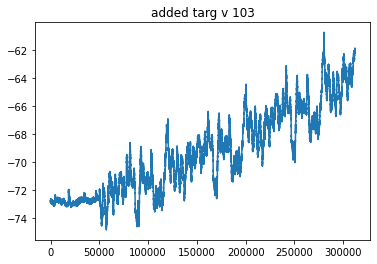

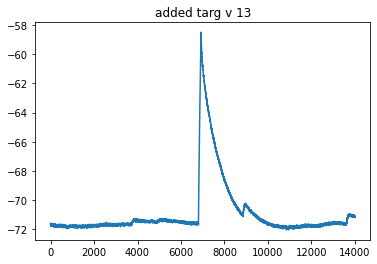

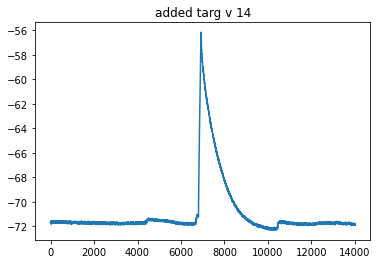

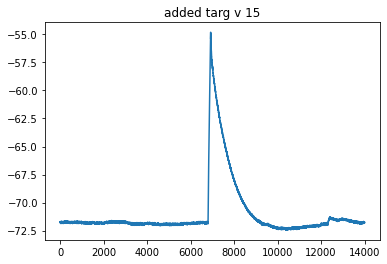

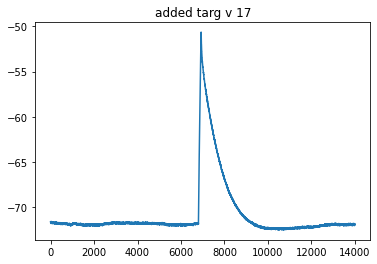

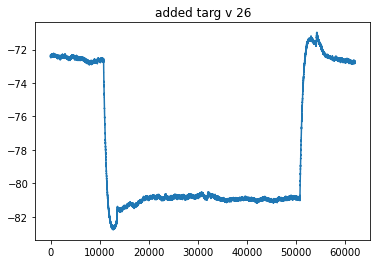

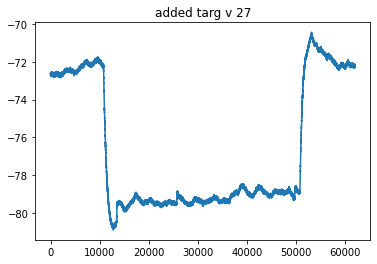

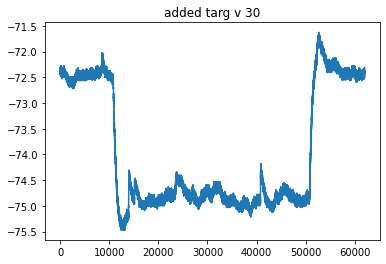

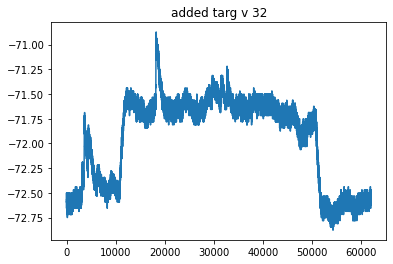

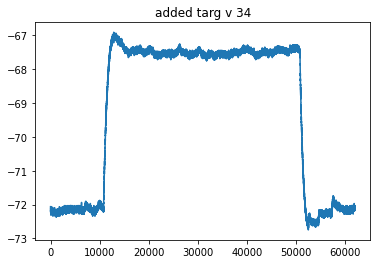

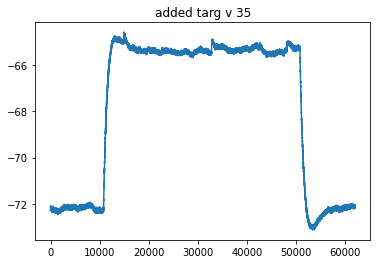

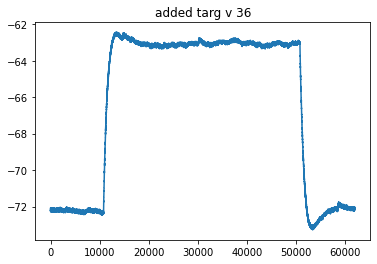

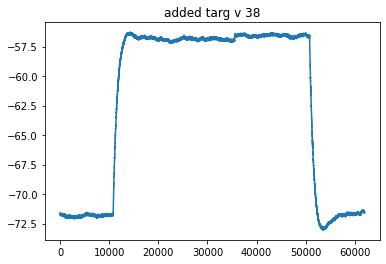

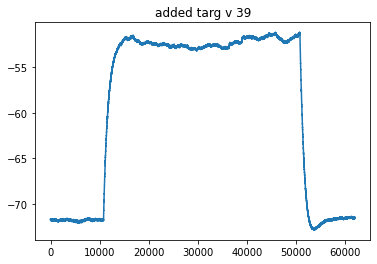

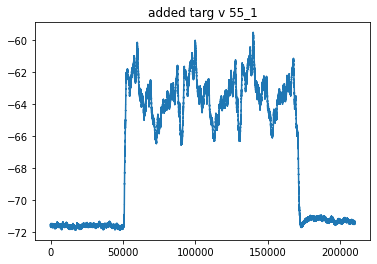

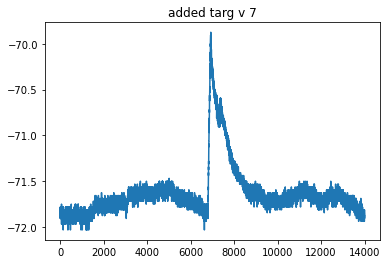

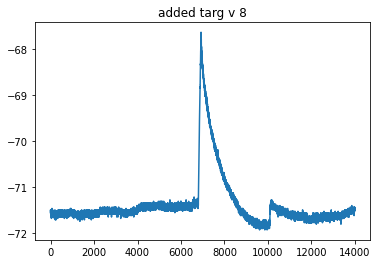

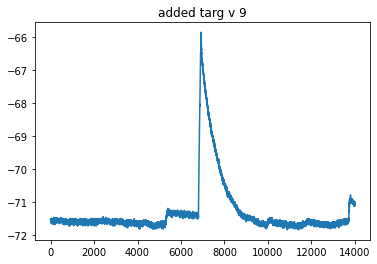

In [75]:
def check_and_remove_fn(fn):
    if os.path.isfile(fn):
        os.remove(fn)
        
def passive_and_save(model_number,show=False):
    all_target_volts = get_target_volts(target_path, model_number )
    all_stims = get_stims(stims_path,model_number)
    # TODO: store these files in var and delete them in case they exist
    stim_path = "results/{}/stims_{}_passive.hdf5".format(model_number,model_number)
    volt_path = "results/{}/target_volts_{}_passive.hdf5".format(model_number,model_number)
    obj_path = "results/{}/allen{}_objectives_passive.hdf5".format(model_number,model_number)
    check_and_remove_fn(stim_path), check_and_remove_fn(volt_path), check_and_remove_fn(obj_path)
    
    stim_f = h5py.File(stim_path, "w")
    volt_f = h5py.File(volt_path, "w")
    obj_f = h5py.File("results/{}/allen{}_objectives.hdf5".format(model_number,model_number), "r")
    new_obj_f = h5py.File(obj_path, "w")
    opt_stim_name_list = []
    # TODO: move filter to be right before choosing and only here
    # you should filter passive here as well
    all_viable = []
    for key in all_target_volts.keys():
        curr_stim = all_stims[key]
        curr_targV = all_target_volts[key]
        if "dt" not in key and 'sweep' not in key and '63' not in key:
            if np.max(curr_targV) > 0 or "dt" in key \
            or np.allclose(curr_stim,0) or key in all_viable:
                continue
            else:
                all_viable.append(key)
    all_viable =np.unique(all_viable)
    choices = np.random.choice(all_viable, min(len(all_viable),35))
    choices = np.unique(choices)
    for key in choices:
        print("processing :", key)
        curr_stim = all_stims[key]
        curr_targV = all_target_volts[key]
        triggered=False
        try:
            min_start = min(np.where(np.array(curr_targV) > -70)[0])
            if min_start > 1000 and min_start < 8000:
                min_start -= 1000
                end = 12000
                print("WARNING : using some weak rule of thumb here")
                #curr_stim = curr_stim[2000:12000]
                #curr_targV = curr_targV[2000:12000]
                triggered=True
        except:
            pass
        curr_stim,dt = sample(curr_stim, 10000)
        curr_targV,_ = sample(curr_targV, 10000)
        # dt doesn't give us exact cut off, this is regrettable
        curr_targV = curr_targV[:10000]
        curr_stim = curr_stim[:10000]
        stim_f.create_dataset(key, data=curr_stim)
        stim_f.create_dataset(key+"_dt", data=[dt])
        volt_f.create_dataset(key, data=curr_targV)
        print(dt)
        opt_stim_name_list.append(key)

        if show:
            if type(show) == int and len(opt_stim_name_list) < show:
                plt.figure()
                plt.title("added targ v " + key)
                #plt.plot(curr_stim)
                plt.plot(np.array(all_target_volts[key]))
            
    
#     num_sfs = len(obj_f['ordered_score_function_list'])
#     np.argwhere([e.decode('ascii') for e in obj_f['ordered_score_function_list'][:]]) == 
#     shaped_weights = obj_f['opt_weight_list'][:].reshape(-1,num_sfs)
#     prev_stims = shaped_weights.shape[0]
#     mean_weights = np.mean(shaped_weights, axis=0)
#     new_weights = np.append(obj_f['opt_weight_list'][:], np.repeat(mean_weights, len(stims_to_add)))
#     assert len(new_weights) / num_sfs == (len(stims_to_add) + prev_stims),"{} != {}".format(len(new_weights) / num_sfs,len(stims_to_add) + prev_stims)

#     new_obj_f.create_dataset('orig_opt_stim_name_list', data=orig_opt_stim_name_list)
    new_weights = np.ones(3000)
    print(opt_stim_name_list, 'opt sim name')
    dt = h5py.special_dtype(vlen=str) 
    opt_stim_name_list = np.array(opt_stim_name_list, dtype=dt) 
    new_obj_f.create_dataset('opt_stim_name_list', data=opt_stim_name_list)
    new_obj_f.create_dataset('opt_weight_list', data=new_weights)
#     new_obj_f.create_dataset('ordered_score_function_list', data=obj_f['ordered_score_function_list'])
    new_obj_f.create_dataset('ordered_score_function_list', data=['chi_square_normal'])

    new_obj_f.close()
    obj_f.close()
    volt_f.close()
    stim_f.close()
    
    print(len(opt_stim_name_list), "stims")
    
passive_and_save(model_number,show=200)

In [76]:
# i = 0
# for idx,key in enumerate(stims.keys()):
# #     if key not in matched_sweep_numbers:
# #         if "dt" in key:
# #             continue
# #         if np.mean(np.array(stims[key]).astype(np.float)) > .01 and i < 20:
# #             plt.figure()
# #             i += 1
#     plt.plot(np.array(stims[key]).astype(np.float))
#     plt.title(key)
#     plt.figure()

In [77]:
#sweep_numbers
sweep_index_to_match,

(['4',
  '23',
  '22',
  '48_3',
  '53_3',
  '51_1',
  '58',
  '48_1',
  '66',
  '48_2',
  '44',
  '16',
  '38',
  '28',
  '13',
  '18',
  '15',
  '14'],)

58 44
0.17000000018807526 0.17000000018807526


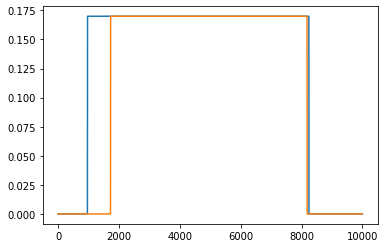

In [35]:
dup1, dup2 = "58", "44"#stim_list_only[7], stim_list_only[11]
plt.plot(stims_to_match[dup1[:]])
plt.plot(stims_to_match[dup2[:]])
print(dup1, dup2)
print(np.max(stims_to_match[dup1[:]]), np.max(stims_to_match[dup2[:]]))

In [64]:
dt1, dt2 = stims_to_match[dup1+"_dt"][0], stims_to_match[dup2+"_dt"][0]

np.sum(np.array(stims_to_match[dup1[:]]) > 0) * dt1, np.sum(np.array(stims_to_match[dup2[:]]) > 0) * dt2
dup1, dup2

('58', '44')

In [34]:
# truelen1  =  10000 / dt1
# print((np.sum(np.array(stims_to_match[dup1[:]]) > 0) *truelen1 ) /10000 )

# truelen2 =  10000 / dt2
# print((np.sum(np.array(stims_to_match[dup2[:]]) > 0) *truelen2 ) /10000 )
    
len(stims.keys())



140

In [14]:
stims_to_match.keys()

<KeysViewHDF5 ['12', '12_dt', '13', '13_dt', '14', '14_dt', '15', '15_dt', '16', '16_dt', '18', '18_dt', '22', '22_dt', '23', '23_dt', '28', '28_dt', '30', '30_dt', '31', '31_dt', '34', '34_dt', '35', '35_dt', '38', '38_dt', '4', '44', '44_dt', '48_1', '48_1_dt', '48_2', '48_2_dt', '48_3', '48_3_dt', '4_dt', '51_1', '51_1_dt', '51_2', '51_2_dt', '53_3', '53_3_dt', '56', '56_dt', '58', '58_dt', '65', '65_dt', '66', '66_dt', '8', '8_dt', '9', '9_dt', 'sweep_keys', 'sweep_numbers']>

In [15]:
stims_to_match['12_dt'][0]

0.034999999999999996

In [16]:
stims_to_match['38_dt'][0]

0.155

In [123]:
stims_to_match['sweep_keys'][:]

array([b'4', b'8', b'9', b'12', b'13', b'14', b'15', b'16', b'18', b'22',
       b'23', b'28', b'30', b'31', b'34', b'35', b'38', b'44', b'48_1',
       b'48_2', b'48_3', b'51_1', b'51_2', b'53_3', b'56', b'58', b'65',
       b'66'], dtype='|S4')

In [124]:
stims_to_match['sweep_numbers'][:]

array([ 4,  5,  6,  8,  9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       28, 30, 31, 34, 35, 36, 38, 43, 44, 46, 47, 48, 50, 51, 53, 56, 57,
       58, 59, 64, 65, 66, 68, 72])

In [182]:
stims_to_match['4']

<HDF5 dataset "4": shape (10000,), type "<f8">